In [76]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
from finitewidth.kernel3_empirical import Kernel3Empirical

In [77]:
# --- Configuration ---
N = 8  # Number of data points (smaller due to computational cost)
D_IN = 10  # Input dimension
M = 256  # Network width
L_VALUES = np.arange(2, 10)  # Network depths
RANDOM_SEED = 42
PATH_TO_PLOTS = "/home/janis/STG3A/deeperorwider/experiments/plots"
PATH_TO_DATA = "/home/janis/STG3A/deeperorwider/experiments/data"

# Ensure paths exist
os.makedirs(PATH_TO_PLOTS, exist_ok=True)
os.makedirs(PATH_TO_DATA, exist_ok=True)

In [78]:
# --- Activation Function ---
def relu(x):
    return jnp.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(x.dtype)

In [79]:
# --- Data and Network Initialization ---
def generate_data(key, n_samples, n_features):
    """Generate random data and normalize it."""
    rng = jax.random.PRNGKey(key)
    data = jax.random.normal(rng, (n_samples, n_features))
    norm = jnp.linalg.norm(data, axis=1, keepdims=True)
    return data / norm

def init_network(key, L, d_in, m):
    
    """Initialize network weights."""
    # the Xavier init operates so we init the weights without scaling sqrt(2/m) as std
    keys = jax.random.split(key, L + 1)
    weights = []
    weights.append(jax.random.normal(keys[0], (m, d_in)) )
    
    for i in range(1, L):
        weights.append(jax.random.normal(keys[i], (m, m)))
    weights.append(jax.random.normal(keys[L], (m,)))
    return weights

def compute_features_and_derivatives(weights, data):
    """we perform a forward pass to get all feature maps and sigma derivatives."""
    H = len(weights) - 1
    m = weights[0].shape[0]

    feature_maps = {0: [x for x in data]}
    sigma_derivatives = {}
    current_activations = feature_maps[0]

    for l in range(1, H + 1):
        W = weights[l-1]
        pre_activations = [W @ x for x in current_activations]
        sigma_derivatives[l] = [jnp.diag(relu_prime(pre_act)) for pre_act in pre_activations]
        current_activations = [(1/jnp.sqrt(m)) * relu(pre_act) for pre_act in pre_activations]
        feature_maps[l] = current_activations
        
    return feature_maps, sigma_derivatives

In [80]:
# --- Main Experiment Loop ---
key_seed = RANDOM_SEED
mean_eigenvalues_per_L = []
std_eigenvalues_per_L = []
inf_norms_per_L = []

print("Starting the analysis of the empirical K3 tensor...")
for L in L_VALUES:
    print(f"Computing for L = {L} layers (M={M})...")

    # Initialization
    key = jax.random.PRNGKey(key_seed)
    key_seed += 1  # Increment seed for next iteration
    weights = init_network(key, L, D_IN, M)
    data = generate_data(key_seed, N, D_IN)  # Use scalar seed directly
    
    # Forward pass to get necessary values
    feature_maps, sigma_derivatives = compute_features_and_derivatives(weights, data)

    # Instantiate the K3 computer
    k3_computer = Kernel3Empirical(weights, sigma_derivatives, feature_maps)

    # Compute the full K3 tensor
    k3_tensor = np.zeros((N, N, N))
    for i in range(N):
        for j in range(i, N):
            for k in range(j, N):
                val = k3_computer.kernel3(i, j, k)
                # Apply symmetry
                k3_tensor[i, j, k] = k3_tensor[i, k, j] = k3_tensor[j, i, k] = \
                k3_tensor[j, k, i] = k3_tensor[k, i, j] = k3_tensor[k, j, i] = val

    # Analyze the tensor
    inf_norm = np.max(np.abs(k3_tensor))
    inf_norms_per_L.append(inf_norm)

    all_slice_eigenvalues = []
    for k in range(N):
        slice_matrix = k3_tensor[:, :, k]
        eigenvalues = np.linalg.eigvalsh(slice_matrix)
        all_slice_eigenvalues.append(eigenvalues)
    
    all_slice_eigenvalues = np.array(all_slice_eigenvalues)
    mean_eigenvalues_per_L.append(np.mean(all_slice_eigenvalues, axis=0))
    std_eigenvalues_per_L.append(np.std(all_slice_eigenvalues, axis=0))

# Convert lists to numpy arrays
mean_eigenvalues_per_L = M*np.array(mean_eigenvalues_per_L)
std_eigenvalues_per_L = M*np.array(std_eigenvalues_per_L)
inf_norms_per_L = M*np.array(inf_norms_per_L)

Starting the analysis of the empirical K3 tensor...
Computing for L = 2 layers (M=100)...
Computing for L = 3 layers (M=100)...
Computing for L = 4 layers (M=100)...
Computing for L = 5 layers (M=100)...
Computing for L = 6 layers (M=100)...
Computing for L = 7 layers (M=100)...
Computing for L = 8 layers (M=100)...
Computing for L = 9 layers (M=100)...


K3 infinity norm plot saved to /home/janis/STG3A/deeperorwider/experiments/plots/k3_inf_norm_vs_L_finite_M100_N8_D10.png
K3 slice eigenvalues plot saved to /home/janis/STG3A/deeperorwider/experiments/plots/k3_slice_eigenvalues_vs_L_finite_M100_N8_D10.png


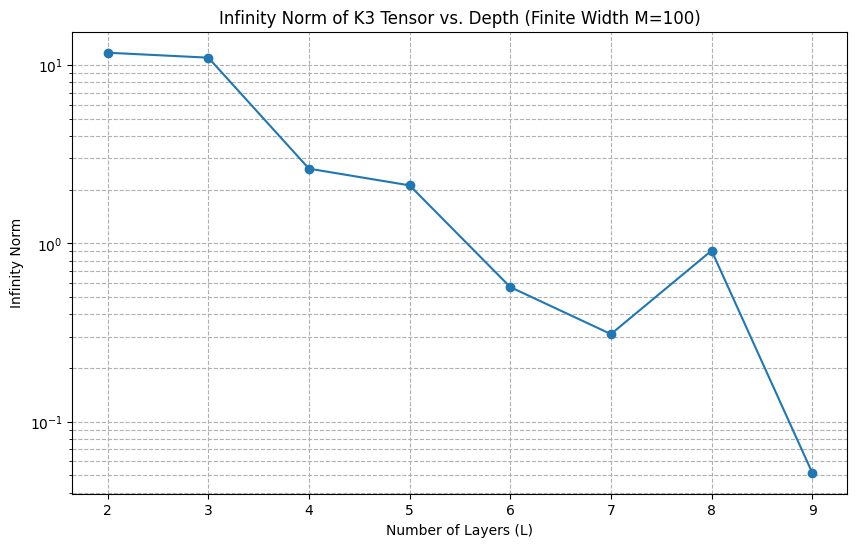

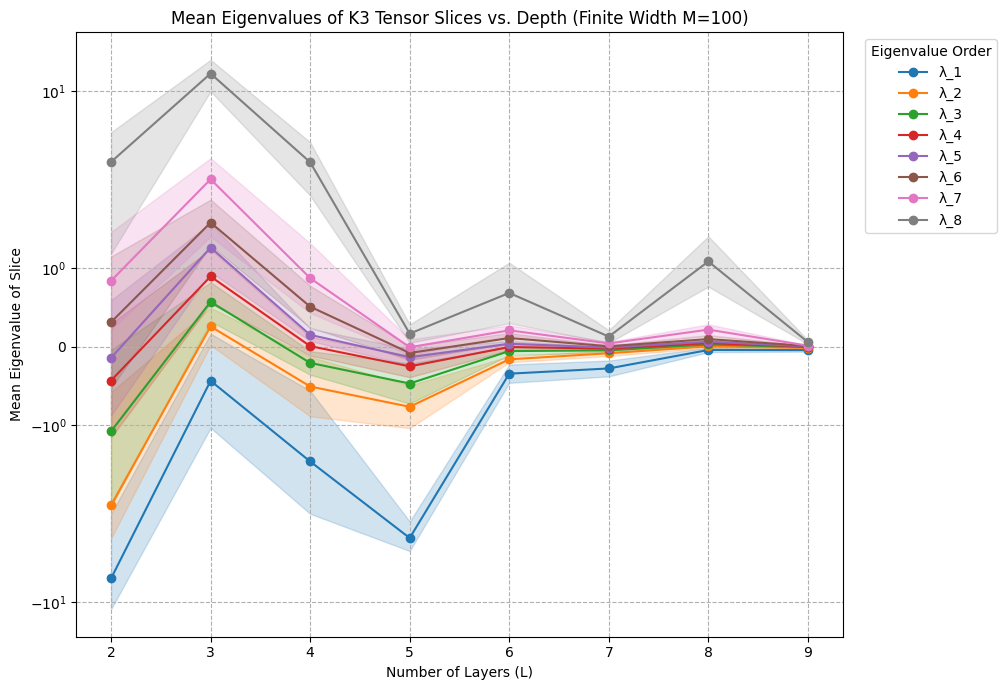

In [81]:
# --- Plotting ---
plot_suffix = f"finite_M{M}_N{N}_D{D_IN}"

# Plot 1: Infinity norm vs. L
plt.figure(figsize=(10, 6))
plt.title(f"Infinity Norm of K3 Tensor vs. Depth (Finite Width M={M})")
plt.plot(L_VALUES, inf_norms_per_L, 'o-')
plt.xlabel("Number of Layers (L)")
plt.ylabel("Infinity Norm")
plt.xticks(L_VALUES)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.savefig(os.path.join(PATH_TO_PLOTS, f"k3_inf_norm_vs_L_{plot_suffix}.png"))
print(f"K3 infinity norm plot saved to {PATH_TO_PLOTS}/k3_inf_norm_vs_L_{plot_suffix}.png")

# Plot 2: Mean eigenvalues vs. L
plt.figure(figsize=(12, 7))
plt.title(f"Mean Eigenvalues of K3 Tensor Slices vs. Depth (Finite Width M={M})")
for k in range(N):
    means = mean_eigenvalues_per_L[:, k]
    stds = std_eigenvalues_per_L[:, k]
    p = plt.plot(L_VALUES, means, 'o-', label=f'λ_{k+1}')
    plt.fill_between(L_VALUES, means - stds, means + stds, alpha=0.2, color=p[0].get_color())

plt.xlabel("Number of Layers (L)")
plt.ylabel("Mean Eigenvalue of Slice")
plt.yscale('symlog')
plt.xticks(L_VALUES)
plt.grid(True, which="both", ls="--")
plt.legend(title="Eigenvalue Order", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig(os.path.join(PATH_TO_PLOTS, f"k3_slice_eigenvalues_vs_L_{plot_suffix}.png"))
print(f"K3 slice eigenvalues plot saved to {PATH_TO_PLOTS}/k3_slice_eigenvalues_vs_L_{plot_suffix}.png")

In [82]:
# --- Save Data ---
## I recall that the data are normalized by multiplying by M
output_data = {
    'l_values': L_VALUES,
    'm_value': M,
    'inf_norms': inf_norms_per_L,
    'mean_eigenvalues': mean_eigenvalues_per_L,
    'std_eigenvalues': std_eigenvalues_per_L,
    'config': {'N': N, 'D_IN': D_IN, 'RANDOM_SEED': RANDOM_SEED}
}
np.save(os.path.join(PATH_TO_DATA, f"k3_analysis_{plot_suffix}.npy"), output_data)
print(f"K3 analysis data saved to {PATH_TO_DATA}/k3_analysis_{plot_suffix}.npy") 

K3 analysis data saved to /home/janis/STG3A/deeperorwider/experiments/data/k3_analysis_finite_M100_N8_D10.npy
